In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder


import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

import env
import acquire_zillow
import prepare
import prepare_2
import wrangle_zillow


---

In [2]:
df = prepare_2.get_zillow_df()

In [3]:
df = prepare_2.wrangle_zillow()

In [4]:
df= prepare_2.engineered_features(df)


In [5]:
#this code is a function in the prepare file that takes in a df and returns split data(train validate and test)
train, validate, test = prepare_2.split_data(df)
train.head()

parcelid  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
51848  12523284          2.0         3.0                        1515.0   
22251  14425080          3.5         4.0                        3971.0   
18204  10956129          1.0         2.0                         910.0   
52042  11265901          2.0         4.0                        2410.0   
4133   12487491          1.0         3.0                        1066.0   

         longitude    latitude  regionidzip  taxvaluedollarcnt  logerror  \
51848 -118131493.0  33787932.0        96247           127532.0 -0.219901   
22251 -117634477.0  33486309.0        96985           561691.0  0.020527   
18204 -118355657.0  34170194.0        96437           550000.0 -0.023169   
52042 -118180778.0  34655632.0        97319           336348.0 -0.334645   
4133  -118109620.0  33842943.0        96213           213231.0  0.043699   

       month  county_Los_Angeles  county_Orange  county_Ventura  price_sqft  \
51848      9                   1              0               0   84.179538   
22251      5                   0              1               0  141.448250   
18204      4                   1              0               0  604.395604   
52042      9                   1              0               0  139.563485   
4133       1                   1              0               0  200.029081   

        age  price_bath  taxvaluedollarcnt_zone    age_bin price_region_bins  
51848  66.0       63766                  395420   60 to 70      350k to 500k  
22251  20.0      160483                  655931   15 to 30      650k to 850k  
18204  76.0      550000                  373306  70 to 160      350k to 500k  
52042  31.0      168174                  238889   30 to 45      100k to 250k  
4133   67.0      213231                  316056   60 to 70      250k to 350k

In [6]:
df.isnull().mean()

parcelid                        0.0
bathroomcnt                     0.0
bedroomcnt                      0.0
calculatedfinishedsquarefeet    0.0
longitude                       0.0
latitude                        0.0
regionidzip                     0.0
taxvaluedollarcnt               0.0
logerror                        0.0
month                           0.0
county_Los_Angeles              0.0
county_Orange                   0.0
county_Ventura                  0.0
price_sqft                      0.0
age                             0.0
price_bath                      0.0
taxvaluedollarcnt_zone          0.0
age_bin                         0.0
price_region_bins               0.0
dtype: float64

---

### Scaling Data
#### the function used is prepare.scaling_minmax. it takes in train, validate and test, copies them and returns scaled versions
#### tried using both the minmax and the standard, however, minmax was more advantageous 
#### here are the columns to scale:
        - calculatedfinishedsquarefeet
        - taxvaluedollarcnt
        - price_sqft
        - price_bath
        - taxvaluedollarcnt_zone
        - logerror


In [7]:
columns_to_scale = ["calculatedfinishedsquarefeet","taxvaluedollarcnt","price_sqft","price_bath","taxvaluedollarcnt_zone","logerror"]
train_scaled, validate_scaled,test_scaled =prepare_2.scaling_minmax(train, validate, test, columns_to_scale)


---

## Exploration

-  According to the features in the zillow dataset, there were atleast 58 features with plenty of information. However, in the end I chose to stick to 17 features. 
-  The following questions arose after doing some of domain research:

1. #### does the logerrror have a relationship with the number of bathrooms or bedrooms ? 
2. #### does price per bathroom have a relationship with logerror?
3. #### does the zipcode affect the logerror?
4. #### does the age of the house logerror? 
5. #### does price per sqfoot have a relationship with logerror?


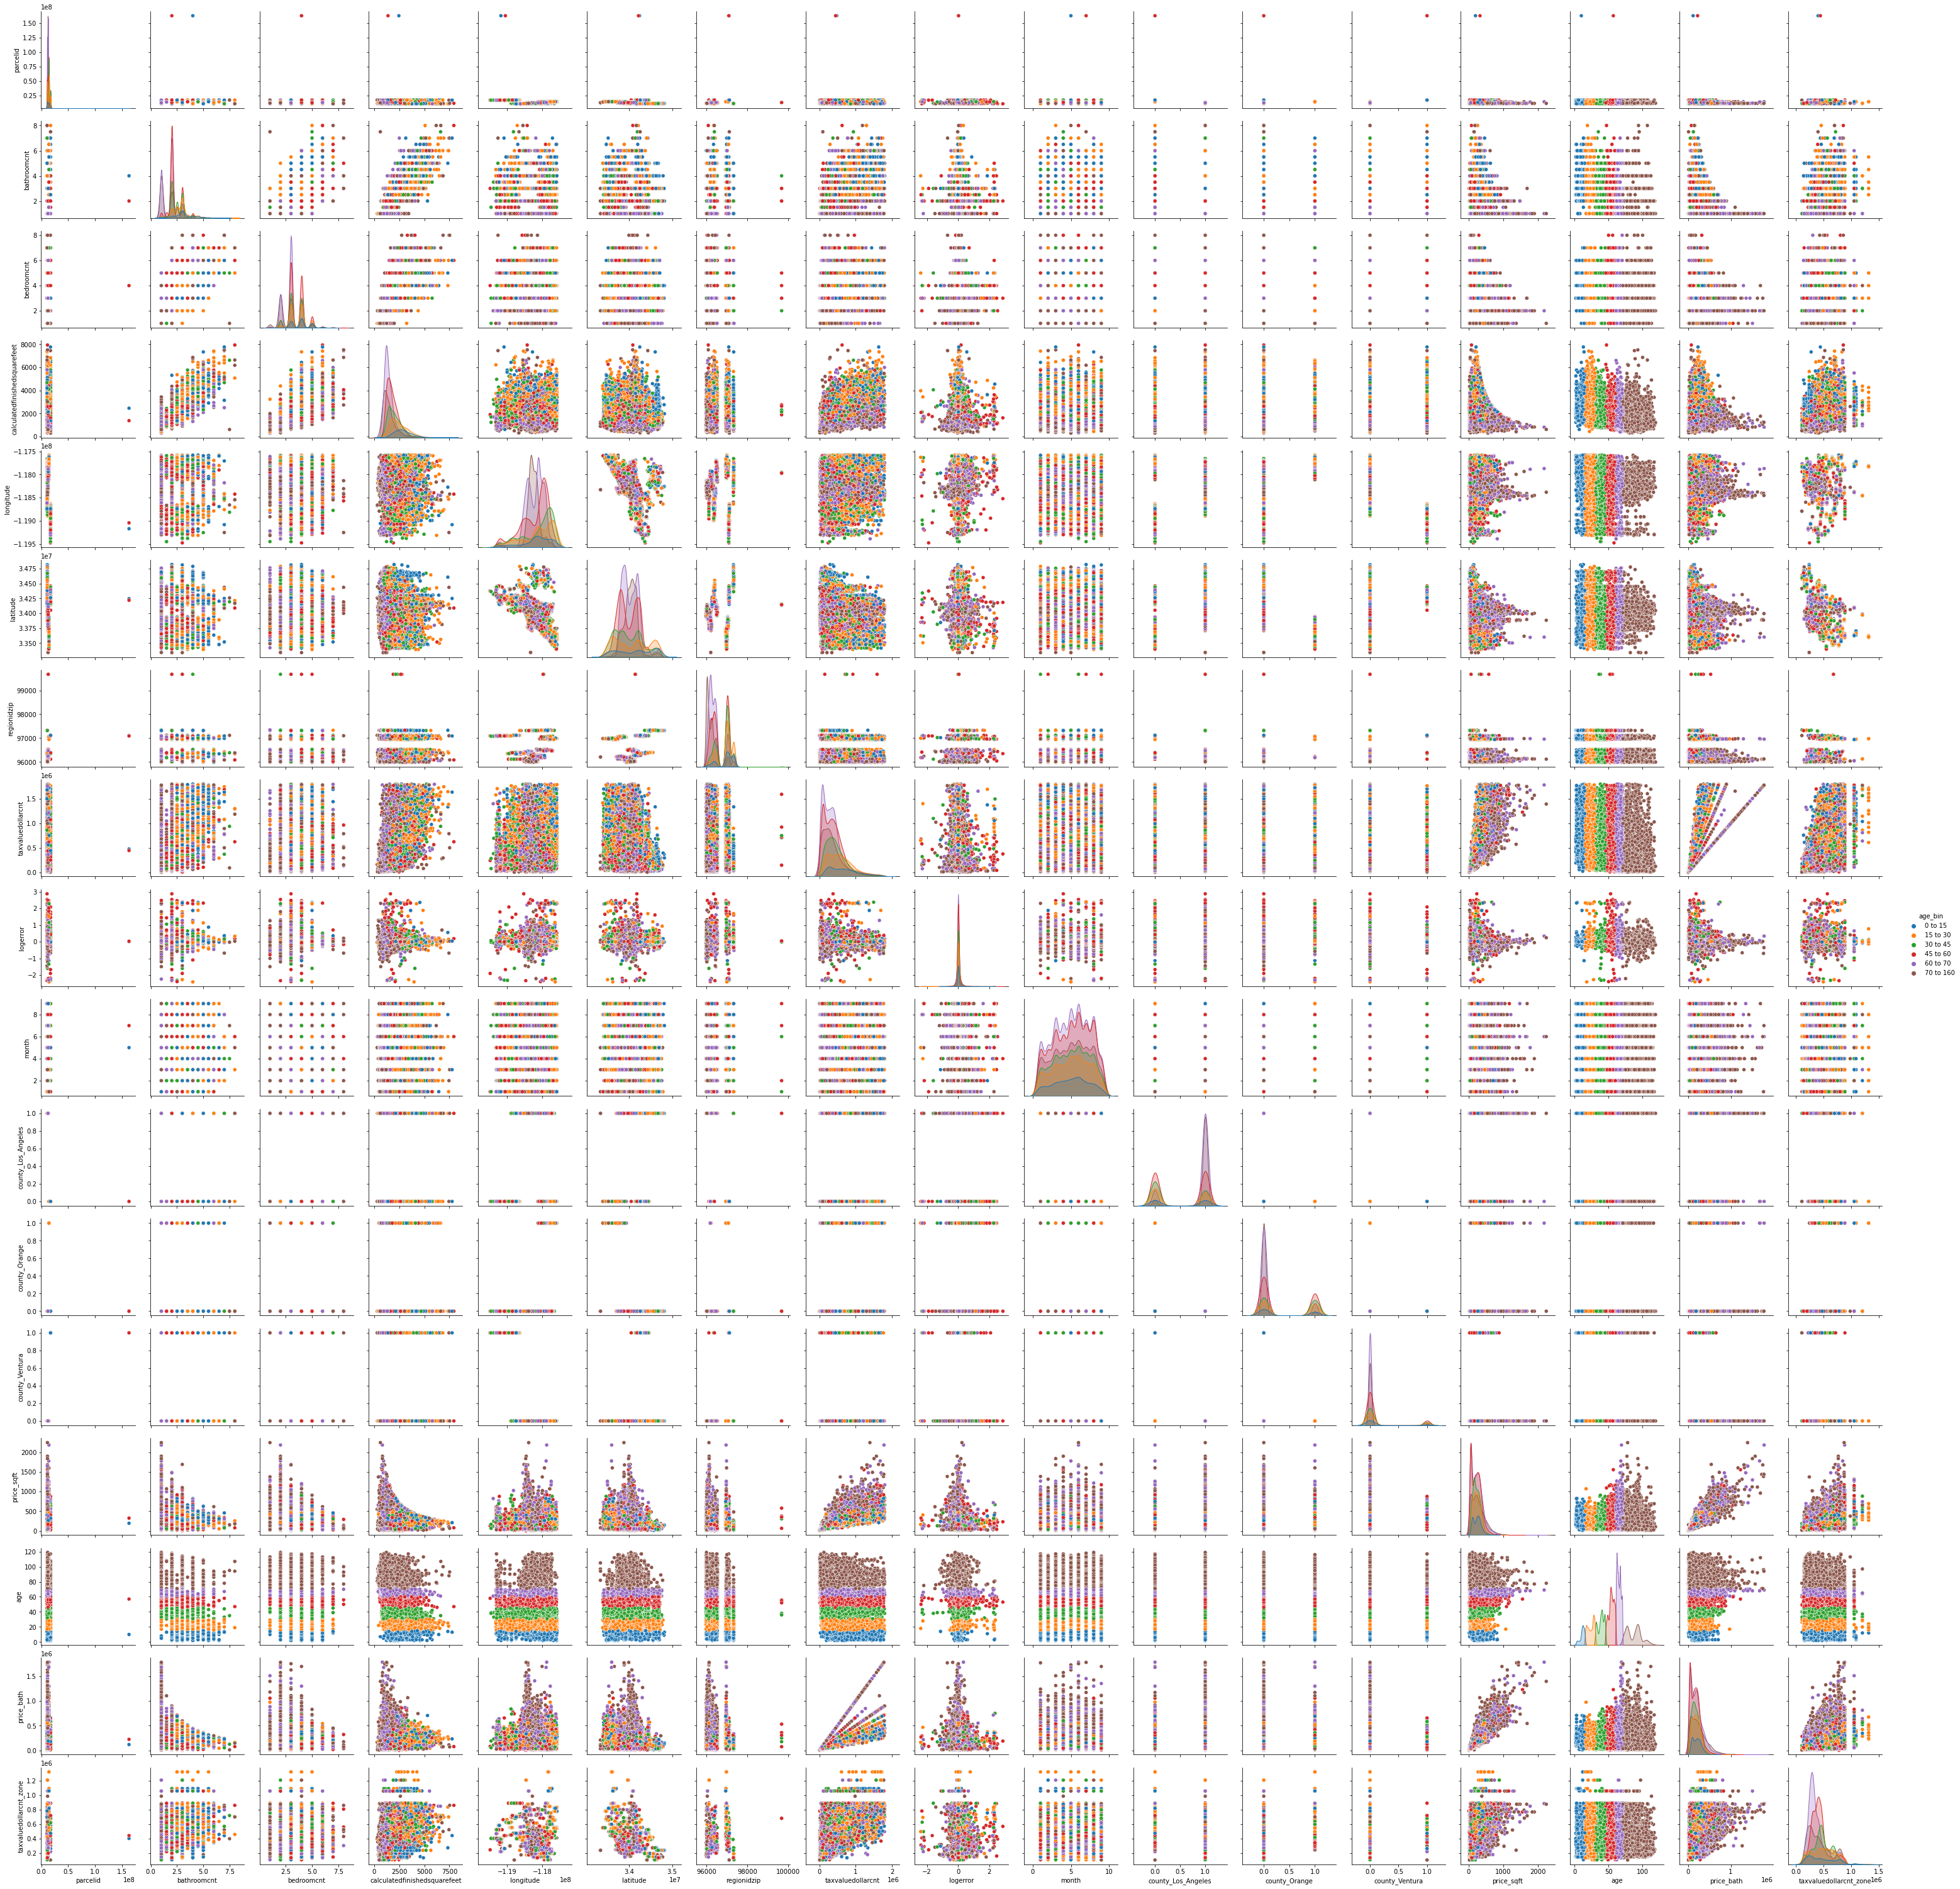

In [34]:

sns.pairplot(data = train, hue = "age_bin")

array([[<AxesSubplot:title={'center':'parcelid'}>,
        <AxesSubplot:title={'center':'bathroomcnt'}>,
        <AxesSubplot:title={'center':'bedroomcnt'}>,
        <AxesSubplot:title={'center':'calculatedfinishedsquarefeet'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'regionidzip'}>,
        <AxesSubplot:title={'center':'taxvaluedollarcnt'}>],
       [<AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'county_Los_Angeles'}>,
        <AxesSubplot:title={'center':'county_Orange'}>],
       [<AxesSubplot:title={'center':'county_Ventura'}>,
        <AxesSubplot:title={'center':'price_sqft'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'price_bath'}>],
       [<AxesSubplot:title={'center':'taxvaluedollarcnt_zone'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dt

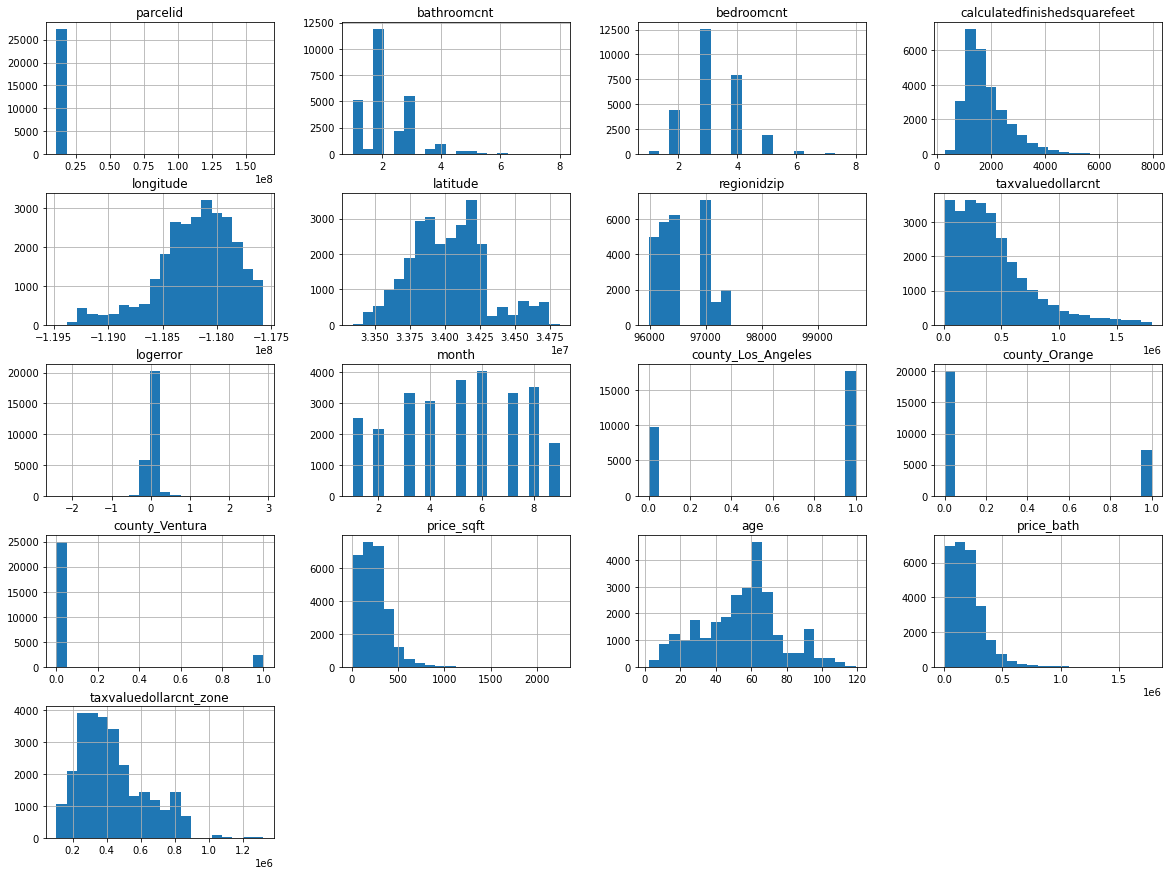

In [35]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


train.hist(bins = 20,figsize =  (20,15))

### 1. does the logerrror have a relationship with the number of bathrooms or bedrooms ? 


No handles with labels found to put in legend.


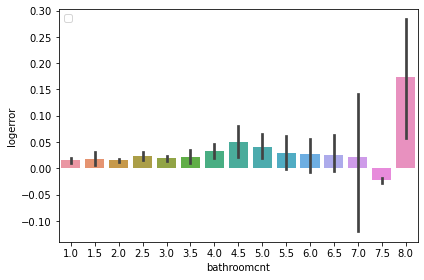

No handles with labels found to put in legend.


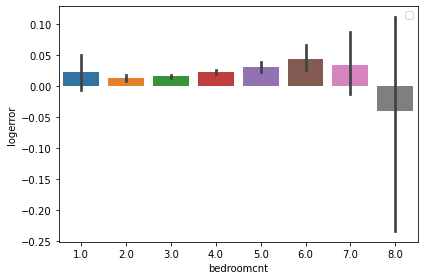

In [8]:
target = train.logerror
columns_to_plot = train[["bathroomcnt","bedroomcnt"]]

# I use a for loop to boxplot my independent variables against our dependent one:
for col in columns_to_plot:
    sns.barplot(x=columns_to_plot[col], y=target, data=columns_to_plot)
    plt.ylabel('logerror')
    plt.xlabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Takeaways
### 1. does the logerrror have a relationship with the number of bathrooms or bedrooms ? 
#### -  it appears that the logerror is signifficantly higher in the average houses (between 6 and 8 bedrooms
#### -  houses with 7.5 bathrooms have a negative log error while houses with 8 have a signifficantly high logerror


---


###  2. does price per bathroom have a relationship with logerror?


<AxesSubplot:xlabel='logerror', ylabel='price_bath'>

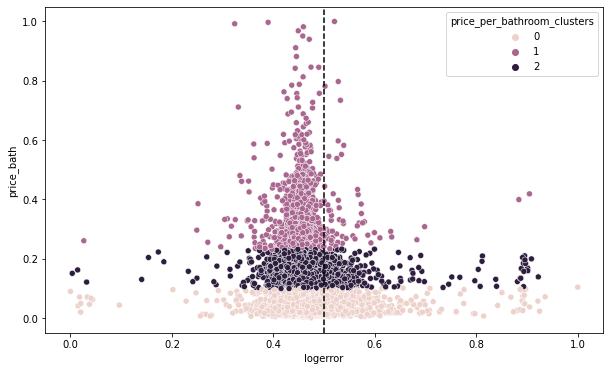

In [9]:
X= train_scaled[["price_bath","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =3, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['price_per_bathroom_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
plt.axvline(x=0.5, color='k', linestyle='--')

sns.scatterplot(x = 'logerror', y = 'price_bath', data = train_scaled, hue = 'price_per_bathroom_clusters')

# sns.scatterplot(x = 'logerror', y = 'price_bath', data = train_scaled, hue = 'clustered_features')


## Takeaways
###  2. does price bathroom have a relationship with logerror?
#### - it appears that the homes within the lower ranges of price per bathrooms have a signifficantly higher logerror
#### - it seems like the ML from zillow is mis pricing the more average homes

---

### 3. does the average price per zone affect the log error?

<AxesSubplot:xlabel='logerror', ylabel='taxvaluedollarcnt_zone'>

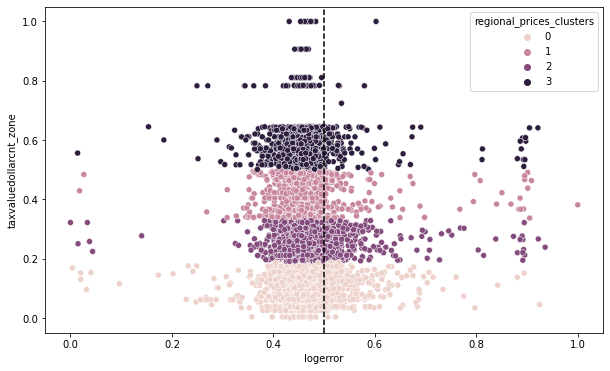

In [10]:
X= train[["taxvaluedollarcnt_zone","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =4, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['regional_prices_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
plt.axvline(x=0.5, color='k', linestyle='--')
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt_zone', data = train_scaled, hue = 'regional_prices_clusters')

# sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt_zone', data = train_scaled, hue = 'clustered_features')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

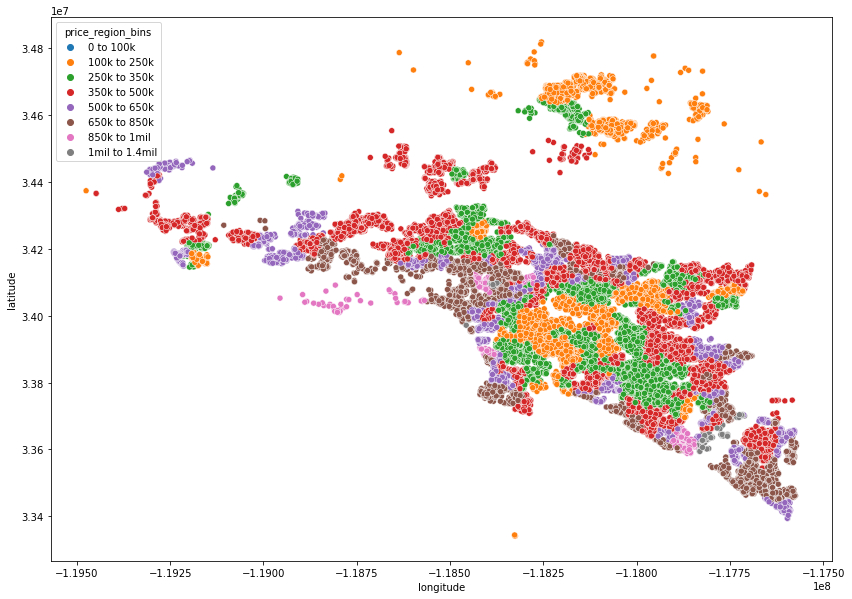

In [11]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=train.price_region_bins, data=train)


## Takeaways
### 3. does the average price per zone affect the log error?
#### - it appears that certain neighborhoods have signifficant price differences
#### - it also shows that properties closer to the coastline tend to be more expensive
#### - zipcodes close to eachother also have similar prices


---

### 4. does the age of the house matter when it comes to the price? 


<AxesSubplot:xlabel='logerror', ylabel='age'>

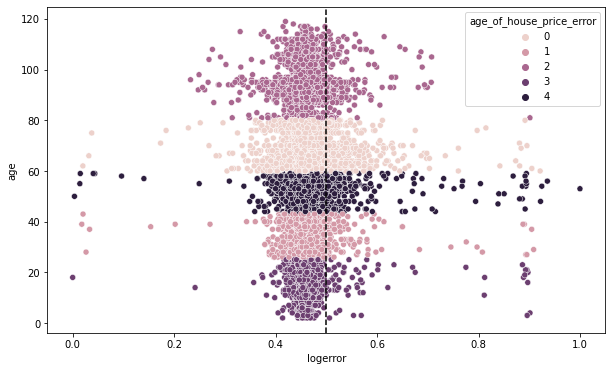

In [12]:
X= train[["age","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =5, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['age_of_house_price_error'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
plt.axvline(x=0.5, color='k', linestyle='--')
sns.scatterplot(x = 'logerror', y = 'age', data = train_scaled, hue = 'age_of_house_price_error')

### Takeaways
### 4. does the age of the house matter when it comes to the price? 

#### - it appears that houses between 50 and 80 years old  have a high posibility of being mis-priced
#### - it also seems like there are not many new homes being built in the past 20 years, unlike other age groups

----

### 5. does price per sqfoot have a relationship with logerror?


<AxesSubplot:xlabel='logerror', ylabel='price_sqft'>

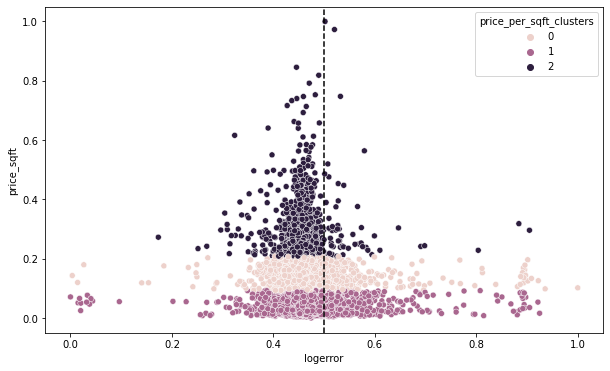

In [13]:
X= train[["price_sqft","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =3, random_state=347)
kmeans.fit(X)
kmeans.predict(X)
train_scaled['price_per_sqft_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
plt.axvline(x=0.5, color='k', linestyle='--')

sns.scatterplot(x = 'logerror', y = 'price_sqft', data = train_scaled, hue = 'price_per_sqft_clusters')

# sns.scatterplot(x = 'logerror', y = 'price_sqft', data = train_scaled, hue = 'clustered_features')


## Takeaways
### 5. does price per sqfoot have a relationship with logerror?

#### -  houses with price per sq footage below 0.2  scaled appear to be a big chunk of the logerror seems like the ML population of error is in the ordinary homes
#### -  isolating these properties and maybe creating a model just for them might be an option a model for these clusters 


---

### Correlation matrix

In [14]:
#getting the correlation matrix vs the logerror column
cor = train_scaled.corr()
cor

parcelid  bathroomcnt  bedroomcnt  \
parcelid                      1.000000     0.112419    0.125774   
bathroomcnt                   0.112419     1.000000    0.628937   
bedroomcnt                    0.125774     0.628937    1.000000   
calculatedfinishedsquarefeet  0.116632     0.830032    0.637997   
longitude                    -0.096597     0.015554    0.007061   
latitude                     -0.249312    -0.004991    0.010852   
regionidzip                   0.364844     0.211820    0.197812   
taxvaluedollarcnt             0.096046     0.502915    0.276244   
logerror                      0.012031     0.025496    0.028785   
month                         0.008209     0.010774    0.009271   
county_Los_Angeles           -0.677465    -0.194356   -0.181254   
county_Orange                 0.338285     0.154394    0.129620   
county_Ventura                0.617790     0.087379    0.103998   
price_sqft                    0.018333    -0.006295   -0.128888   
age                          -0.248499    -0.537151   -0.378764   
price_bath                    0.007986    -0.097369   -0.101195   
taxvaluedollarcnt_zone        0.167997     0.366127    0.154523   
price_per_bathroom_clusters   0.101684     0.027961    0.000621   
regional_prices_clusters      0.150403     0.287995    0.138927   
age_of_house_price_error      0.214837     0.247842    0.261176   
price_per_sqft_clusters      -0.134332    -0.104829   -0.083519   

                              calculatedfinishedsquarefeet  longitude  \
parcelid                                          0.116632  -0.096597   
bathroomcnt                                       0.830032   0.015554   
bedroomcnt                                        0.637997   0.007061   
calculatedfinishedsquarefeet                      1.000000   0.014746   
longitude                                         0.014746   1.000000   
latitude                                         -0.029039  -0.535140   
regionidzip                                       0.179882   0.195375   
taxvaluedollarcnt                                 0.568965  -0.000991   
logerror                                          0.029488   0.034387   
month                                             0.007844  -0.005635   
county_Los_Angeles                               -0.195346  -0.152781   
county_Orange                                     0.152492   0.601954   
county_Ventura                                    0.092037  -0.684380   
price_sqft                                       -0.034281  -0.029365   
age                                              -0.476440  -0.113566   
price_bath                                        0.067142  -0.029429   
taxvaluedollarcnt_zone                            0.406619  -0.000434   
price_per_bathroom_clusters                       0.129440   0.016442   
regional_prices_clusters                          0.310726  -0.055670   
age_of_house_price_error                          0.229054   0.034751   
price_per_sqft_clusters                          -0.098801  -0.044041   

                              latitude  regionidzip  taxvaluedollarcnt  \
parcelid                     -0.249312     0.364844           0.096046   
bathroomcnt                  -0.004991     0.211820           0.502915   
bedroomcnt                    0.010852     0.197812           0.276244   
calculatedfinishedsquarefeet -0.029039     0.179882           0.568965   
longitude                    -0.535140     0.195375          -0.000991   
latitude                      1.000000     0.099493          -0.191008   
regionidzip                   0.099493     1.000000          -0.006654   
taxvaluedollarcnt            -0.191008    -0.006654           1.000000   
logerror                     -0.034475     0.019698          -0.004769   
month                        -0.008905    -0.003440           0.013438   
county_Los_Angeles            0.464755    -0.610161          -0.164565   
county_Orange                -0.665695     0.497239         

## Takeaways
#### - After running a correlation matrix,  
#### - there were no significant corelation coefficients, with the logerror
#### - therefore more statistical tests are needed

---

## Hypothesis testing 

- In this section I will be checking the wheather the relationhip to log error is random 
- Afterwards, I will proceed to pick 2 of the best features to model with

### Price per sqfeet

$H 0 $: Price per squareft has no effect on the logerror

$H1$: Price per sqft affects the logerror

In [15]:
a = 0.05

In [16]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.price_sqft
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I failed to reject the null hypothesis")


corr = -0.03200
p = 0.00000
I reject the null hypothesis


---

###  Price per bathroom

$H 0 $: Price per bathroom has no effect o the logerror

$H1$: Price per bathroom has an effect on logerror 

In [17]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.price_bath
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I failed reject the null hypothesis")

corr = -0.03068
p = 0.00000
I reject the null hypothesis


---

### Price per region

$H 0 $: average price of the  region has no effect o the logerror

$H 1 $: average price of the  region has an effect on the logerror

In [18]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.taxvaluedollarcnt_zone
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I fail to reject the null hypothesis")

corr = 0.00570
p = 0.34568
I fail to reject the null hypothesis


---

### calculatedfinishedsquarefeet

#### $H 0 $:  the size  of the house has no effect on the logerror
#### $H 1 $: the size  of the house has an effect on the logerror

In [27]:
x = train_scaled.calculatedfinishedsquarefeet
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I fail to reject the null hypothesis")

corr = 0.02949
p = 0.00000
I reject the null hypothesis


---

### price_per_bathroom_clusters

#### $H 0 $ price per bathroom value does not influence the logerror
#### $H 1 $price per bathroom is a factor when it comes to logerror

In [28]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.price_per_bathroom_clusters
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I failed to reject the null hypothesis")


corr = -0.01637
p = 0.00674
I reject the null hypothesis
